In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
import shutil
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset_path = '/content/drive/MyDrive/dataset'
train_path = '/content/drive/MyDrive/dataset/train_dataset'
test_path = '/content/drive/MyDrive/dataset/train_dataset'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#transformation for dataset

transform = transforms.Compose([transforms.Resize((299,299)),transforms.ToTensor()])

In [6]:
dataset = datasets.ImageFolder(dataset_path,transform = transform)

In [7]:
dataloader = DataLoader(dataset,batch_size = 32,shuffle = True)

In [8]:
dataitem = iter(dataloader)
images,label = next(dataitem)

In [9]:
#mean and standard deviation calculation
batch_size = 32
m = torch.zeros(3)
std = torch.zeros(3)
n=0
for images,_ in dataloader:
    batch_sample = images.size(0)
    n += batch_sample
    m += images.mean(dim=(0,2,3))*batch_sample
    std += images.std(dim = (0,2,3))*batch_sample

m = m/n
std = std/n
m,std

(tensor([0.7194, 0.7180, 0.6539]), tensor([0.2365, 0.2361, 0.3225]))

In [10]:
#train transform and test transform
train_transform = transforms.Compose([transforms.Resize((299,299)),
                                     transforms.RandomRotation(15),
                                     transforms.RandomHorizontalFlip(0.3),
                                     transforms.RandomVerticalFlip(0.3),
                                     transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(m,std)])

test_transform = transforms.Compose([transforms.Resize((299,299)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(m,std)])

In [11]:
train_dataset = datasets.ImageFolder(train_path,transform = train_transform)
test_dataset = datasets.ImageFolder(test_path,transform = test_transform)

In [12]:
train_loader = DataLoader(train_dataset,batch_size = 16,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = 16,shuffle = True)

In [13]:
class_mango = []
for v,i in train_dataset.class_to_idx.items():
    class_mango.append(v)
class_mango

['Ashshina Zhinuk',
 'Bari -11',
 'Chausa',
 'Fazli',
 'Gourmati',
 'Harivanga',
 'Harumanis',
 'Katimon',
 'Langra']

In [14]:
dataitem = iter(train_loader)
images,labels = next(dataitem)

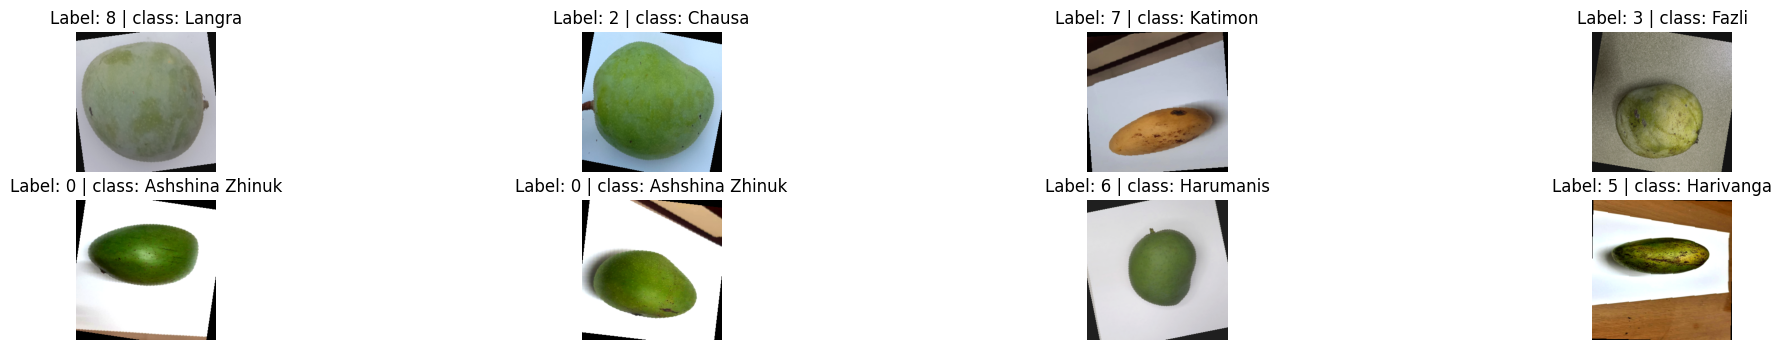

In [15]:
#training data visualization
def denormalize(img,m,std):
    m = m[:,None,None]
    std = std[:,None,None]
    return (img*std)+m

fig,axes = plt.subplots(2,4,figsize = (25,4))
c = 0
for i in range (2):
    for j in range(4):
        img = denormalize(images[c],m,std)
        img = np.clip(img,0,1)
        axes[i][j].imshow(img.permute(1,2,0).numpy())
        axes[i][j].axis('off')
        axes[i][j].set_title(f'Label: {labels[c]} | class: {class_mango[labels[c]]}')
        c+=1
plt.show()

In [16]:
#create an instance for Network
model = models.inception_v3(pretrained = True).to(device)
model.fc = nn.Linear(2048,9)
model = model.to(device)

#Instance for a loss function
criteria = nn.CrossEntropyLoss()

#Instance for a Optimizer function
optimizer = SGD(model.parameters(),lr = 0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 170MB/s] 


In [17]:
#saving the model parameters
torch.save(model.state_dict(),'model.pth')

In [18]:
#Training Loop

epochs = 20
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    running_loss = 0
    test_loss = 0

    model.train()

    for images,labels in train_loader:

        images,labels = images.to(device),labels.to(device)

        #getting the ouputs form the model
        output,_  = model(images)

        #calculating Loss
        loss= criteria(output,labels)

        #turning previous gradients to zero
        optimizer.zero_grad()

        #backpropogating to calculate gradient
        loss.backward()

        #taking step for optimization
        optimizer.step()

        running_loss +=loss.item()
    running_loss /=len(train_loader)
    train_loss_list.append(running_loss)

    model.eval()

    for images,labels in test_loader:

        images,labels = images.to(device),labels.to(device)

        output = model(images)

        loss = criteria(output,labels)

        test_loss += loss.item()
    test_loss /=len(test_loader)
    test_loss_list.append(test_loss)
    print(f"For epoch: {epoch+1} train loss: {running_loss:.3f} test loss: {test_loss:.3f}")

correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"The accuracy of model is: {accuracy}%")



For epoch: 1 train loss: 2.033 test loss: 1.813
For epoch: 2 train loss: 1.524 test loss: 1.235
For epoch: 3 train loss: 1.013 test loss: 0.745
For epoch: 4 train loss: 0.727 test loss: 0.472
For epoch: 5 train loss: 0.536 test loss: 0.321
For epoch: 6 train loss: 0.416 test loss: 0.207
For epoch: 7 train loss: 0.346 test loss: 0.156
For epoch: 8 train loss: 0.288 test loss: 0.115
For epoch: 9 train loss: 0.227 test loss: 0.082
For epoch: 10 train loss: 0.200 test loss: 0.070
For epoch: 11 train loss: 0.186 test loss: 0.061
For epoch: 12 train loss: 0.174 test loss: 0.051
For epoch: 13 train loss: 0.156 test loss: 0.043
For epoch: 14 train loss: 0.148 test loss: 0.034
For epoch: 15 train loss: 0.129 test loss: 0.029
For epoch: 16 train loss: 0.113 test loss: 0.026
For epoch: 17 train loss: 0.102 test loss: 0.021
For epoch: 18 train loss: 0.109 test loss: 0.017
For epoch: 19 train loss: 0.086 test loss: 0.015
For epoch: 20 train loss: 0.090 test loss: 0.013
The accuracy of model is: 100

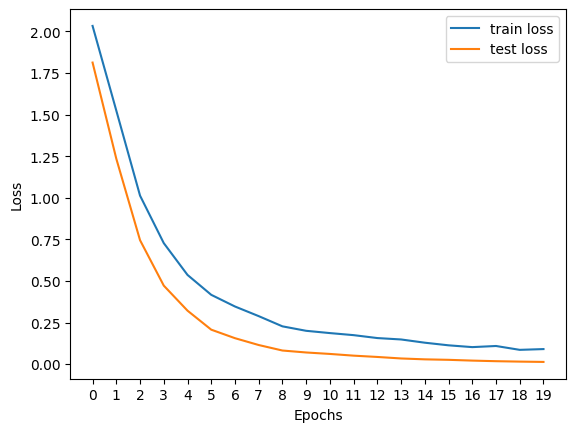

In [20]:
plt.plot(range(epochs),train_loss_list,label = 'train loss')
plt.plot(range(epochs),test_loss_list,label = 'test loss')
plt.xticks(range(epochs))
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [21]:
images,labels = next(iter(test_loader))

Text(0.5, 1.0, 'Label: 3 | class: Fazli')

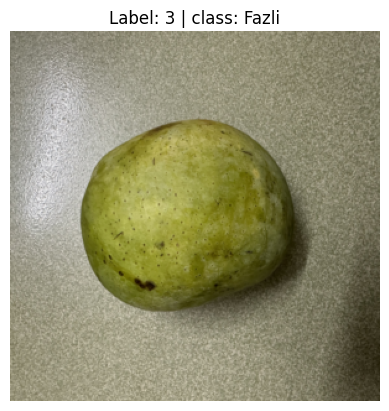

In [22]:
img = denormalize(images[11],m,std)
img = np.clip(img,0,1)
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.title(f'Label: {labels[11]} | class: {class_mango[labels[11]]}')

In [23]:
model.eval()

with torch.no_grad():
  output = model(img.unsqueeze(0).to(device))
  output = F.softmax(output,dim=1)
output

tensor([[9.2289e-04, 2.3810e-03, 1.6960e-02, 9.6199e-01, 1.1134e-03, 2.0709e-03,
         1.1406e-03, 2.3707e-03, 1.1048e-02]], device='cuda:0')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Ashshina Zhinuk'),
  Text(1, 0, 'Bari -11'),
  Text(2, 0, 'Chausa'),
  Text(3, 0, 'Fazli'),
  Text(4, 0, 'Gourmati'),
  Text(5, 0, 'Harivanga'),
  Text(6, 0, 'Harumanis'),
  Text(7, 0, 'Katimon'),
  Text(8, 0, 'Langra')])

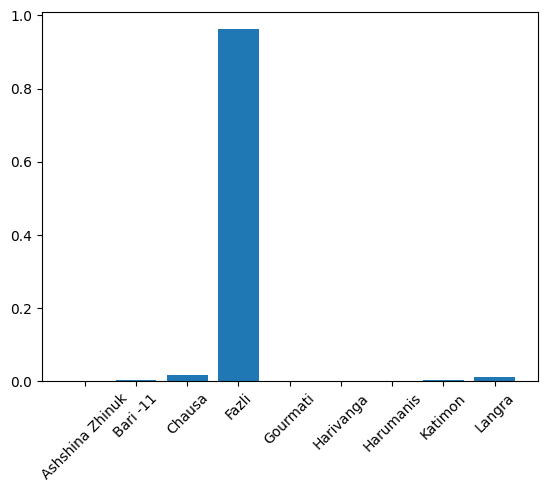

In [24]:
#Visualizing the prediction on test data
plt.bar(class_mango,output.cpu().numpy()[0])
plt.xticks(rotation = 45)